<a href="https://colab.research.google.com/github/hwon-n/section6_project1/blob/main/CP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -U pandas-profiling

In [3]:
import pandas as pd
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
# 데이터 불러오기

train = pd.read_csv('/content/drive/MyDrive/Training Data.csv')
test = pd.read_csv('/content/drive/MyDrive/Test Data.csv')

train.shape, test.shape

((252000, 13), (28000, 12))

In [5]:
target = 'Risk_Flag'
train, val = train_test_split(train, train_size = 0.8, random_state = 42, stratify = train[target])
train.shape, val.shape

((201600, 13), (50400, 13))

### 데이터 확인


In [6]:
train.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

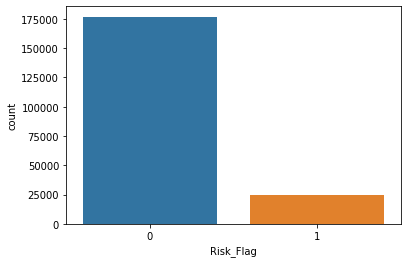

In [8]:
%matplotlib inline

ax = sns.countplot(data = train, x = target)
plt.show()

# 0 -> 1로 바꿔주기
# 0: 대출 가능, 1: 대출 불가능 

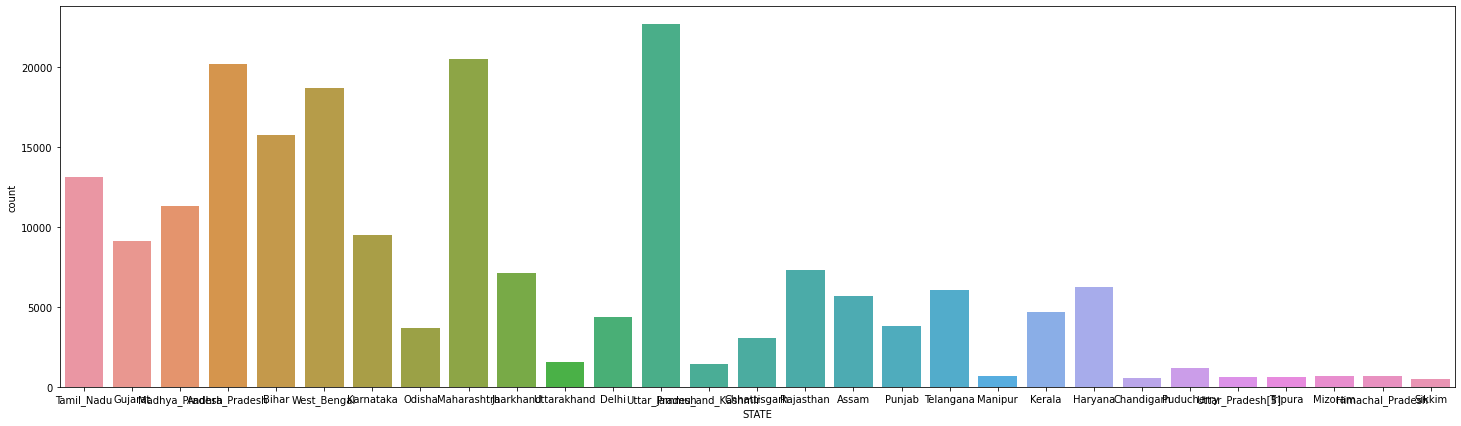

In [30]:
# STATE 탐색

plt.figure(figsize=(25,7))
ax = sns.countplot(data = train, x = 'STATE')
plt.show()

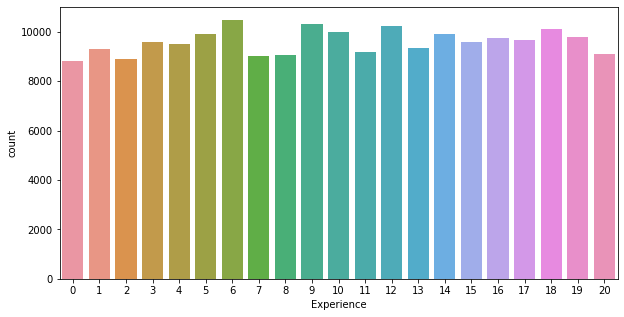

In [33]:
# Experience 탐색

plt.figure(figsize=(10,5))
ax = sns.countplot(data = train, x = 'Experience')
plt.show()

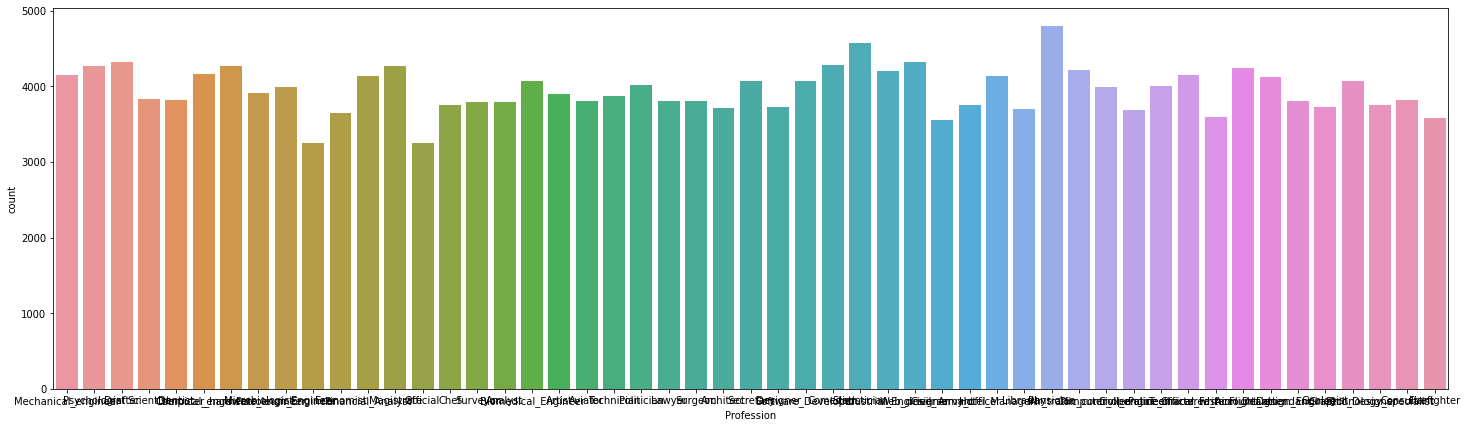

In [36]:
# Profession 탐색

plt.figure(figsize=(25, 7))
ax = sns.countplot(data = train, x = 'Profession')
plt.show()